# About

In this notebook, you will learn about the problem of brain tumor segmentation, and how Machine Learning has the potential to assist radiologists in this task. You will also learn about the types and grades of different tumors. You will explore two different kinds of data - (1) patient information, and (2) Magnetic Resonance Imaging data.

# Learning Objectives

> In this file, you will learn the following:
>    
><ol>
>  <li>The problem of Brain Tumor (Glioma) Segmentation</li>
>  <li>Glioma and Subtypes</li>
>  <li>Exploring Patient Characteristics</li>
>  <li>Exploring MRI Data</li>
></ol>

## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 1. The problem of Brain Tumor (Glioma) Segmentation

Correct and timely tumor segmentation could significantly prolong the life-span of patients with brain tumors. Radiologists use non-invasive brain imaging techniques (e.g., Magnetic Resonance Imaging (MRI)) to determine the presence, location and extent of the tumor for treatment planning (e.g., radiotherapy and surgery. Treatment planning requires precise segmentation to ensure that the treatment is effective in resecting the bulk of the tumor, without unnecessarily affecting functional brain areas. Radiologists rely on their years of training and practice to estimate the extent of tumor location and spread as precisely as possible. However, manually marking MRI scans for large number of patients is tedious and time-consuming and could delay timely diagnosis and lead to diagnostic errors. Hence, research in Machine Learning (ML) focuses on developing algorithms that have the potential to assist in tumor segmentation for correct diagnosis and efficient treatment planning.

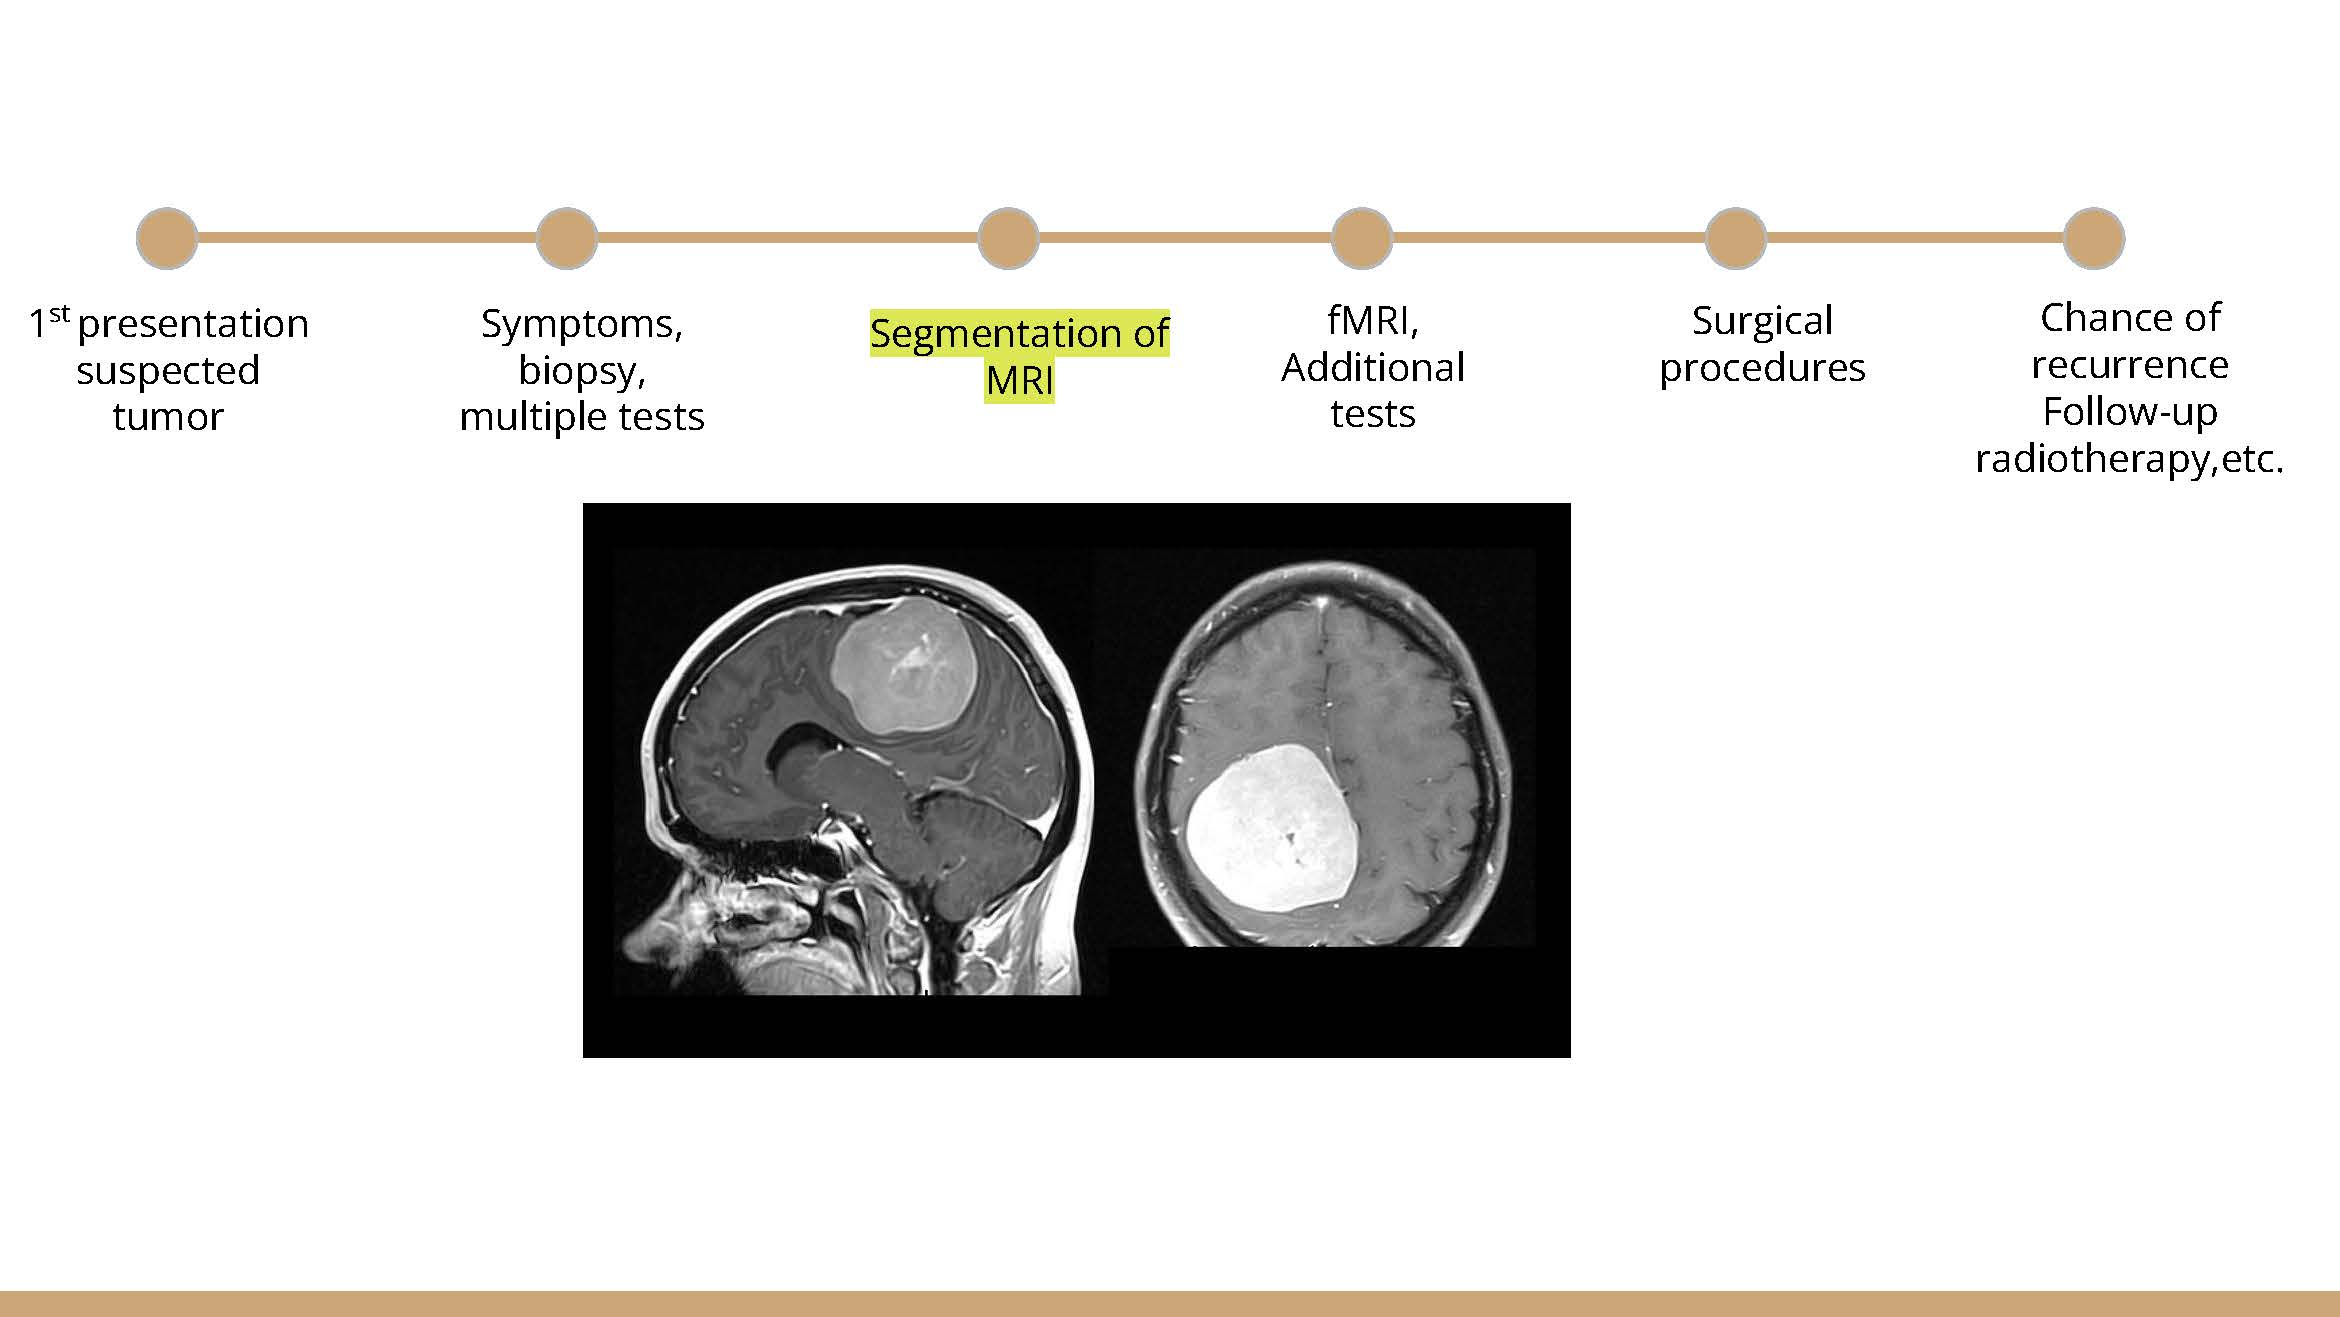

## 2. Glioma and Subtypes

In this notebook, you will explore two kinds of brain tumors, namely, low grade glioma and glioblastoma multiforme (a type of high grade glioma). These two types have different prognosis and treatment plans:

- Glioblastoma Multiforme (GBM), is the most aggressive of high grade gliomas as is usually treated by surgical resection of the tumor followed by radiotherapy. In this case, accurate delineation of tumor margins is required to ensure effective dosage to tumor region.
<br>
<br>
- Low grade gliomas (LGG), though less aggressive than GBM, can undergo progression into high grade tumors. Due to this, a more conservative management (“wait-and-watch”) approach is adopted. Segmentation is important in this scenario to monitor temporal, morphological and volumetric alterations of the tumors during observation.

https://www.cancer.gov/about-cancer/diagnosis-staging/prognosis/tumor-grade-fact-sheet

<h3> ** In this analysis, we will only work with the training dataset. ** </h3>

In [ ]:
df = pd.read_csv('./data/patient_data.csv',index_col=0)
df.info()

In [ ]:
##[1]: Get the list of patients in training dataset.
ptrain = np.load('./data/train_patients.npy').tolist()

##[2]: Now, get only those rows of the patient data that correspond to these patients.
df = df.loc[df['Case'].isin(ptrain)]

In [ ]:
#First, we will see if the dataset has any missing values:
null_data = df[df.isnull().any(axis=1)]
null_data

Data can be missing for a number of reasons. From the documentation, it looks like this particular subject [withdrew their consent](https://gdac.broadinstitute.org/runs/stddata__2016_01_28/samples_report/GBM_Redactions.html). Respecting that, we will drop this row from all further analysis.

In [ ]:
null_data.index[0]

In [ ]:
df = df.drop([null_data.index[0]], axis=0)

In [ ]:
#Checking if all null columns are dropped:
df[df.isnull().any(axis=1)]

In [ ]:
#Now, we will take a look at the different types of tumor that the dataset contains.
tumor_types = df[['Tissue source site', 'Study', 'Histology', 'Grade']]
tumor_types

In [ ]:
#What are the subtypes of Lower Grade Glioma? 
lgg_subtypes = tumor_types[tumor_types['Study'] == 'Brain Lower Grade Glioma']['Histology'].unique()
print('\nSubtypes of Low Grade Glioma are: ', lgg_subtypes)

#Subtypes of Glioblastoma multiforme?
gbm_subtypes = tumor_types[tumor_types['Study'] == 'Glioblastoma multiforme']['Histology'].unique()
print('\nSubtypes of Glioblastoma Multiforme are: ', gbm_subtypes)

In [ ]:
#How are these different subtypes graded?
df.groupby(['Grade','Histology']).count()

In [ ]:
#Are there any correlations between Tissue source site, Study, Histology and Grade?

#First, we will copy the data on tumor types to a new file:
plot_df = tumor_types.copy()

# The data is categorial we first convert it to ordinal data with LabelEncoder:
labelencoder=LabelEncoder()
for column in plot_df.columns:
    plot_df.loc[:, column] = labelencoder.fit_transform(plot_df[column])
    
#Then, we compute the correlation matrix and plot it like a heatmap:
plt.figure(figsize=(14,12))
sns.heatmap(plot_df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

## 3. Exploring Patient Characteristics

In [ ]:
#How many patients have Lower Grade Glioma and how many have Glioblastoma multiforme?
df[['Study','Case']].groupby(['Study']).count()

In [ ]:
#What is the mean survival (months) for different types of tumor? 
df[['Survival (months)','Histology']].groupby(['Histology']).mean()

In [ ]:
#Is mean survival (months) normally distributed?
#For this, we will use the Shapiro Wilk test of normality.
shapiro_test = stats.shapiro(df['Survival (months)'])
shapiro_test

In [ ]:
#By the p-value, we can tell the data is not normal. Let's see what it really looks like:
sns.displot(df, x='Survival (months)')

#Distribution by histology:
# sns.displot(df, x='Survival (months)', hue='Histology')

In [ ]:
#Which tissue source site has the most number of patients?
df[['Tissue source site','Case']].groupby('Tissue source site').count()

In [ ]:
#What is the median age at diagnosis?
df[['Age (years at diagnosis)']].median()[0]

In [ ]:
#Does the gender of the patient have an effect on survival?

## 4. Visualising Patient Cases with MRI Data

In [ ]:
def get_data_by_case(case):
    MRI = np.load('./data/train_images/{}_image.npy'.format(case))
    tumor = np.load('./data/train_labels/{}_label.npy'.format(case))
    return MRI, tumor

In [ ]:
def plot_figure(MRIData, TumorData, z_slice):

    plt.figure(figsize=(25, 15))

    plt.subplot(1, 5, 1)
    plt.imshow(MRIData[z_slice,:,:,0], cmap="bone", origin="lower")
    plt.title("FLAIR")


    plt.subplot(1, 5, 2)
    plt.imshow(MRIData[z_slice,:,:,1], cmap="bone", origin="lower")
    plt.title("T1w")


    plt.subplot(1, 5, 3)
    plt.imshow(MRIData[z_slice,:,:,2], cmap="bone", origin="lower")
    plt.title("t1gd")

    plt.subplot(1, 5, 4)
    plt.imshow(MRIData[z_slice,:,:,3], cmap="bone", origin="lower")
    plt.title("T2w")
    
    plt.subplot(1, 5, 5)
    plt.imshow(TumorData[z_slice,:,:,0], cmap="viridis", origin="lower")
    plt.title("Tumor")
    
    plt.show()

Now, you will explore the Magnetic Resonance Imaging (MRI) data from The Cancer Genome Atlas (TCGA). The data consists of pre-operative multimodal MR imaging sequences (i.e., T1, T1-Gd, T2, T2-FLAIR) along with their whole-tumor segmentation labels composed of edema, enhancing tumor, and non-enhancing tumor. We have combined these labels into a single whole tumor for this project. Each patient is associated with 144 pre-operative MRI scans, which were treated as independent data points for 2D segmentation. These MRI scans were cropped to 144 × 144 pixels and further pre-processed the data by pixel-intensity normalization.

<b> [4.1] &nbsp; Pick a patient who identifies as female and has a low survival (months) with high grade tumor. What does the MRI scan look like? What does the tumor look like?</b>

In [ ]:
#Based on the survival curve above, I will eyeball and assume "low" survival as anything less than 20 months:
condition1 = df['Gender']=='female'
condition2 = df["Survival (months)"] < 20
condition3 = df['Grade'] == 'G3'

In [ ]:
#Getting data that satisfies all the above conditions together:
case1 = df[(condition1) & (condition2) & (condition3)]

In [ ]:
# Looks like there are many patients that satisfy this criteria:
len(case1)

In [ ]:
#So, I will randomly pick a patient:
patient1 = case1.sample(random_state=0)
patient1

In [ ]:
#Now, I will fetch the MRI scans and radiologist-annotated tumor from the training image files:
# pcase = patient1['Case'].values[0]
# patient1_MRI, patient1_tumor = get_data_by_case(pcase)

pcase = 'TCGA-02-0060'
patient1_MRI, patient1_tumor = get_data_by_case(pcase)

In [ ]:
#Each patient has 144 images (along the z-axis) of size 144x144 pixels.
#There are a total of 4 different modalities for each image:
patient1_MRI.shape

```
INPUT CHANNELS:  "modality": {
	 "0": "FLAIR",
	 "1": "T1w",
	 "2": "t1gd",
	 "3": "T2w"
 },
LABEL_CHANNELS: "labels": {
	 "0": "background",
	 "1": "edema",
	 "2": "non-enhancing tumor",
	 "3": "enhancing tumour"
 }
 
```

In [ ]:
#Similarly, patient has segmentations corresponding to each of the 144 images (along the z-axis) of size 144x144 pixels.
#There is only 1 annotation for tumor:
patient1_tumor.shape

In [ ]:
for i in range(36,52):
    plot_figure(patient1_MRI, patient1_tumor, z_slice=i)

<b> [4.2] &nbsp; Out of all patients with low grade glioma, which patient has the largest tumor? What are the patient characteristics? What do the MRI Scans and the tumor look like?</b>

In [ ]:
##[1]: Get the list of patients in training dataset.
lgg_patients = df[df['Study'] == 'Brain Lower Grade Glioma']['Case'].values
lgg_patients

In [ ]:
#Now, we will access each of the patient files, and compute the tumor size (in pixels):
tumor_size = []
for patient in lgg_patients:
    tumor_data = np.load('./data/train_labels/{}_label.npy'.format(patient))
    tumor_size.append(tumor_data.sum())

In [ ]:
#Now, let's see what percentage of the total brain surface is the tumor:
total = 144*144*144
percent_tumor = [(x/total)*100 for x in tumor_size]
sns.histplot(percent_tumor)
plt.ylabel('Percentage Tumor')

In [ ]:
maxp = max(percent_tumor)
idx = percent_tumor.index(max_p)
patient_with_largest = lgg_patients[idx]
patient_with_largest

In [ ]:
#Get data of the patient and then plot images:
largest_lgg_MRI, largest_lgg_tumor = get_data_by_case(patient_with_largest)
for i in range(36,52):
    plot_figure(largest_lgg_MRI, largest_lgg_tumor, z_slice=i)